In [1]:
import pandas as pd
import altair as alt

In [2]:
alt.renderers.enable('png')
#alt.renderers.enable('mimetype')

RendererRegistry.enable('png')

## Intro

- Dates of the press conferences
- Motivation: learning in MDS program
- The end to end analysis can be found in this notebook (link)

### Scraping & Cleaning Briefing Transcripts
The daily coronavirus briefing transcripts are actually available on rev.com as cleaner `.txt` files, but I wanted to practice using the BeautifulSoup package for web scraping as part of this project. The scraped transcripts are included in the repo, but `scrape_briefings.py` can be ran to scrape the raw transcripts for yourself.

In [3]:
# %run scrape_briefings.py

In [4]:
# import scraped csv to pandas df
briefings_df = pd.read_csv('../data/all_briefings.csv')
briefings_df

,date,timestamp,speaker,text
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ..."
...,...,...,...,...
9677,2020-04-27,01:01:23,Reporters,[crosstalk 00:13:23].
9678,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back."
9679,2020-04-27,01:01:26,Speaker 16,If an American president loses more Americans ...
9680,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo..."


### Checking for null values:

In [5]:
briefings_df[briefings_df['text'].isnull()]

,date,timestamp,speaker,text
7217,2020-04-13,16:03,Donald Trump,NaN
8339,2020-04-19,23:03,Andrew Cuomo,NaN
9181,2020-04-22,01:15:03,Dr. Birx,NaN


Manually comparing with the full transcripts and videos we can see these correspond to the speaker being cut off or uttering something inaudible. Let's simply drop these three rows.

In [6]:
briefings_df = briefings_df.dropna(subset=['text']).reset_index(drop=True)

### Cleaning up speaker names

In [7]:
# how many paragraphs of text for the top speakers?
briefings_df['speaker'].value_counts()[:50]

Donald Trump              4013
Mike Pence                 751
Dr. Birx                   244
Dr. Fauci                  237
John                       161
Deborah Birx               101
Admiral Giroir              94
Dr. Deborah Birx            94
Speaker 8                   93
Speaker 7                   92
Speaker 5                   88
Steve Mnuchin               84
Speaker 12                  82
Speaker 11                  82
Speaker 22                  79
Speaker 3                   78
Speaker 9                   76
Speaker 10                  76
Speaker 4                   73
Speaker 6                   73
Speaker 13                  72
Speaker 14                  68
Speaker 2                   65
Speaker 19                  64
Speaker 15                  61
Speaker 16                  60
Mike Pompeo                 59
Reporter                    58
Jeff                        56
Vice President Pence        53
Speaker 23                  52
Speaker 18                  52
Speaker 

Looking at the output above and inspecting the data in more detail we can see there's opportunity to:
- Consolidate numbered unnamed speakers and reporters, since numbering is not consisent across briefings
- Note specific recurring reports who are referred to by first name
- Standardize the name used for other important speakers who have multiple spellings/titles/variations present

In [8]:
# replace speaker names using basic regex
briefings_df['speaker'].replace(regex={r'.*Trump.*': 'Donald Trump', 
                                       r'.*Pence.*': 'Mike Pence',
                                       r'.*Fauci.*': 'Dr. Anthony Fauci',
                                       r'.*Birx.*': 'Dr. Deborah Birx',
                                       r'.*Berks.*': 'Dr. Deborah Birx',
                                       r'.*Pompeo.*': 'Mike Pompeo',
                                       r'.*Report.*': 'Unnamed (Reporter)',
                                       r'.*Audience Member.*': 'Unnamed',
                                       r'.*Speaker .*': 'Unnamed', 
                                       r'.*Jeff\Z': 'Jeff (Reporter)',
                                       r'.*John\Z': 'John (Reporter)',
                                       r'.*Peter\Z': 'Peter (Reporter)',
                                       r'.*Jim\Z': 'Jim (Reporter)',
                                       r'.*Steve\Z': 'Steve (Reporter)',
                                       r'.*Pete\Z': 'Pete Gaynor',
                                       r'.*Novarro.*': 'Peter Navarro',
                                       r'.*Surgeon General.*': 'Jerome Adams',
                                       r'.*Giroir.*': 'Brett Giroir',
                                       r'.*Polowczyk.*': 'John Polowczyk',
                                       r'.*Verma.*': 'Seema Verma',
                                       r'.*Azar.*': 'Alex Azar',
                                       r'.*Hahn.*': 'Dr. Steven Hahn',
                                       r'.*Mnuchin.*': 'Steve Mnuchin'},
                                inplace = True)

In [9]:
# how many paragraphs of text per speaker?
top_speaker_counts = briefings_df['speaker'].value_counts()[:25]
top_speaker_counts

Donald Trump          4091
Unnamed               2038
Mike Pence             849
Dr. Deborah Birx       491
Dr. Anthony Fauci      317
Unnamed (Reporter)     215
John (Reporter)        162
Steve Mnuchin          136
Brett Giroir           100
Mike Pompeo             81
Dr. Steven Hahn         64
Alex Azar               63
Seema Verma             56
Jeff (Reporter)         56
John Polowczyk          49
Jerome Adams            48
Jim (Reporter)          47
Steve (Reporter)        46
Peter Navarro           35
Peter (Reporter)        33
Jared Kushner           23
General Semonite        23
Kelly                   23
Mark Esper              22
Jim Acosta              19
Name: speaker, dtype: int64

In [10]:
briefings_df

,date,timestamp,speaker,text
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ..."
...,...,...,...,...
9674,2020-04-27,01:01:23,Unnamed (Reporter),[crosstalk 00:13:23].
9675,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back."
9676,2020-04-27,01:01:26,Unnamed,If an American president loses more Americans ...
9677,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo..."


### Emotion Analysis using the NRC Emotion Lexicon

- Rather than using just the simple TextBlob or Vader packages for sentiment analysis, I thought it would be interesting to explore emotional tone using
- Let's see what we can uncover using the popular open-sourced emotion lexicon published by the NRC (National Research Council Canada).
- In addition to 'positive' and 'negative', we have word associations for 8 overarching emotion categories.
- For simplicity, let's remove words without scores as well as those that are associated with 8 or more of the 10 categories 

In [11]:
# read in raw emotion lexicon
filepath = "../NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=1, sep='\t')

# pivot df so we have one row per word, one column per emotion
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()

# rename df column
emolex_df.columns.name = 'index'

# filter out words without scores, as well as those with more than 7 scores
emolex_df = emolex_df[emolex_df.sum(axis=1)>0].reset_index(drop=True)
emolex_df = emolex_df[emolex_df.sum(axis=1)<7].reset_index(drop=True)
emolex_df

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,0,0,0,0,0,0,0,0,0,1
1,abandon,0,0,0,1,0,1,0,1,0,0
2,abandoned,1,0,0,1,0,1,0,1,0,0
3,abandonment,1,0,0,1,0,1,0,1,1,0
4,abba,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6437,zany,0,0,0,0,0,0,0,0,1,0
6438,zeal,0,1,0,0,1,0,1,0,1,1
6439,zealous,0,0,0,0,1,0,1,0,0,1
6440,zest,0,1,0,0,1,0,1,0,0,1


#### Using this lexicon, we can now easily lookup values for all of the words in a single paragraph of the corpus:

In [12]:
paragraph_words = briefings_df.text[504].split()
emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(paragraph_words).any(1)]

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
80,action,0,0,0,0,0,0,1,0,0,0
1182,considerable,0,0,0,0,0,0,1,0,0,0
1460,deal,0,1,0,0,1,0,1,0,1,1
4088,opportunity,0,1,0,0,0,0,1,0,0,0
5736,task,0,0,0,0,0,0,1,0,0,0
6091,unprecedented,0,0,0,0,0,0,0,0,1,0


#### Let's calculate and store aggregate emotion scores for each paragraph in the corpus:

In [13]:
# create empty df to store aggregated emotion calcs
data = pd.DataFrame([])

for text in briefings_df['text']:
    paragraph_words = text.split()
    paragraph_emos = emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(paragraph_words).any(1)].mean()
    data = data.append(paragraph_emos, ignore_index=True)
    
# combine aggregated emotion scores with transcript df
briefings_df = briefings_df.join(data)

# drop empty 'word' column, fill NaNs with zero
briefings_df = briefings_df.drop(columns=['word'])
briefings_df = briefings_df.fillna(0)

briefings_df

,date,timestamp,speaker,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,0.230769,0.230769,0.153846,0.307692,0.153846,0.461538,0.307692,0.230769,0.153846,0.153846
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,0.125000,0.500000,0.250000,0.375000,0.125000,0.375000,0.500000,0.125000,0.125000,0.375000
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,0.000000,0.272727,0.000000,0.090909,0.363636,0.000000,0.818182,0.090909,0.181818,0.454545
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,0.222222,0.333333,0.000000,0.222222,0.333333,0.333333,0.555556,0.000000,0.111111,0.333333
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...",0.000000,0.285714,0.000000,0.142857,0.142857,0.428571,0.285714,0.142857,0.000000,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,2020-04-27,01:01:23,Unnamed (Reporter),[crosstalk 00:13:23].,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9675,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9676,2020-04-27,01:01:26,Unnamed,If an American president loses more Americans ...,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
9677,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo...",0.166667,0.333333,0.000000,0.166667,0.166667,0.333333,0.500000,0.166667,0.166667,0.166667


# Topic Modelling

In [14]:
import spacy
from pandarallel import pandarallel
import re
import gensim.corpora as corpora
from gensim import models
import pyLDAvis.gensim

In [15]:
# Load English spacy model and stop words
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

In [16]:
# function for preprocessing each paragraph of transcript text
def preprocess(text, 
               min_token_len = 2, 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']): 
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text 
    and return a preprocessed list of strings. 
    
    Parameters
    -------------
    text : (str) 
        the text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (list) the preprocessed text as a list of strings
    """
    
    # convert input string to lowercase
    text = text.lower()

    # remove multiple whitespace characters
    text = re.sub(r'\s+',' ', text)
    
    # tokenize with spacy, exluding stop words, short tokens, 
    # irrelevant POS, emails, urls, and strings containing 
    # non-alphanumeric chars
    
    doc = nlp(text)
    token_list = []
    for token in doc:
        if token.is_stop == False and len(token.text)>=min_token_len \
            and token.pos_ not in irrelevant_pos and token.like_email == False \
            and token.like_url == False and token.text.isalnum():
            token_list.append(token.lemma_)
        
    return token_list

#### Pre-process the raw text prior to topic modelling:

In [17]:
# parallelize preprocessing to reduce execution time
pandarallel.initialize(verbose=False)

# apply preprocessor to each row of text
briefings_df['pp_text'] = briefings_df.text.parallel_apply(preprocess)

In [18]:
briefings_df['pp_text']

0       [thank, thank, begin, like, extend, deep, cond...
1       [lot, people, think, turn, good, thing, number...
2       [total, 15, take, japan, hear, american, citiz...
3       [china, know, start, speak, president, xi, gre...
4       [bring, specialist, regarded, specialist, tomo...
                              ...                        
9674                                          [crosstalk]
9675                                                [let]
9676    [american, president, lose, americans, course,...
9677    [yeah, lose, lot, people, look, original, proj...
9678    [press, talk, ventilator, want, talk, okay, re...
Name: pp_text, Length: 9679, dtype: object

#### Create dictionary and document-term co-occurence matrix
- here we're using the gensim topic modelling package

In [19]:
# build dictionary
corpus = briefings_df['pp_text'].tolist()
dictionary = corpora.Dictionary(corpus)
len(dictionary)

7911

In [20]:
# build dictionary and filter extremes, removing tokens that appear in
# either: fewer than 5 paragraphs, or in more than 10% of all paragraphs
dictionary = corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below = 10, no_above = 0.1)
len(dictionary)

2037

In [21]:
# define words to be manually removed and retrieve their indexes
remove_words = ['crosstalk', 'question', 'inaudible', 'mr', 'sir', 'dr']
del_indexes = [k for k,v in dictionary.items() if v in remove_words]

# remove unwanted word ids from the dictionary
dictionary.filter_tokens(bad_ids=del_indexes)

In [22]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

#### Build and visualize the topic model:

In [23]:
lda_model = models.LdaModel(corpus=doc_term_matrix,
                      id2word=dictionary,
                      num_topics=6,
                      passes=20,
                      random_state=123)

In [24]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054672 -0.289469       1        1  13.044097
1      0.222367  0.005122       2        1  19.765024
2     -0.123680  0.099529       3        1  22.420975
3     -0.019933  0.097242       4        1  15.147667
4      0.208270  0.040015       5        1  16.646456
5     -0.232351  0.047560       6        1  12.975780, topic_info=            Term         Freq        Total Category  logprob  loglift
434         test  1746.000000  1746.000000  Default  30.0000  30.0000
1012     testing  1121.000000  1121.000000  Default  29.0000  29.0000
295          new  1428.000000  1428.000000  Default  28.0000  28.0000
176     governor  1473.000000  1473.000000  Default  27.0000  27.0000
322     business   604.000000   604.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1602  ventilator   160.672516   865.495728   Topic6  -4.8906   0.3582
202       effort   130.992279   280.172791   Topic6  -5.0948   1.2818
190         vice   125.731140   369.036896   Topic6  -5.1358   0.9653
246         meet   123.211304   233.880508   Topic6  -5.1560   1.4012
101          day   124.649330  1225.462036   Topic6  -5.1444  -0.2435

[389 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1850      4  0.997117   abbott
868       4  0.888849  ability
868       6  0.103055  ability
232       1  0.126517     able
232       3  0.069584     able
...     ...       ...      ...
560       2  0.386529      yes
560       4  0.007293      yes
560       5  0.608966      yes
545       3  0.028976     york
545       5  0.969940     york

[694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

After experimenting with different numbers of topics and filtering out extreme tokens, we see pretty good results with the following 6 topics being identified:
Note the interactive output from pyLDAvis package.

In [25]:
topic_labels = {0:'Economy',
                1:'International',
                2:'Policy & Guidelines',
                3:'Testing',
                4:'Ventilators & NY Outbreak',
                5:'PPE'
               }

### Use the topic model to predict a topic for each text:

In [26]:
def get_most_prob_topic(unseen_document, model = lda_model):
    """
    Given an unseen_document, and a trained LDA model, this function
    finds the most likely topic (topic with the highest probability) from the 
    topic distribution of the unseen document and returns the best topic
    
    Parameters
    ------------
    unseen_document : (str) 
        the document to be labeled with a topic
    model : (gensim ldamodel) 
        the trained LDA model
    
    Returns: 
    -------------
        (str) the most likely topic label
    
    Examples:
    ----------
    >> get_most_prob_topic("We're building so so so many ventilators.", 
                            model = lda)
    Ventilators
    """
    
    # preprocess unseen text and obtain bow vector
    unseen_doc_pp = preprocess(unseen_document)
    bow_vector = dictionary.doc2bow(unseen_doc_pp)
    
    # calculate topic scores for unseen text
    scores_df = pd.DataFrame(lda_model[bow_vector], columns =['topic', 'score']) 
    
    # find topic name of max score
    topic_name = topic_labels[scores_df.loc[scores_df['score'].idxmax(), 'topic']]
    best_score = scores_df['score'].max()
    
    return topic_name, best_score;

In [27]:
# create empty lists to store prediction strings
predictions = []
scores = []

# call function for each unseen text, appending predictions to list
for text in briefings_df['pp_text'].tolist():
    # we'll only predict a topic for texts where there are 4 or more token words present
    if len(text) > 4:
        topic, value = get_most_prob_topic(' '.join(text))
        predictions.append(topic)
        scores.append(value)
    else:
        predictions.append(None)
        scores.append(None)

# add prediction values to main df
briefings_df['topic_pred'] = predictions
briefings_df['topic_score'] = scores

In [28]:
briefings_df

,date,timestamp,speaker,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pp_text,topic_pred,topic_score
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,0.230769,0.230769,0.153846,0.307692,0.153846,0.461538,0.307692,0.230769,0.153846,0.153846,"[thank, thank, begin, like, extend, deep, cond...",International,0.544385
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,0.125000,0.500000,0.250000,0.375000,0.125000,0.375000,0.500000,0.125000,0.125000,0.375000,"[lot, people, think, turn, good, thing, number...",Policy & Guidelines,0.573967
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,0.000000,0.272727,0.000000,0.090909,0.363636,0.000000,0.818182,0.090909,0.181818,0.454545,"[total, 15, take, japan, hear, american, citiz...",International,0.337955
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,0.222222,0.333333,0.000000,0.222222,0.333333,0.333333,0.555556,0.000000,0.111111,0.333333,"[china, know, start, speak, president, xi, gre...",International,0.599763
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...",0.000000,0.285714,0.000000,0.142857,0.142857,0.428571,0.285714,0.142857,0.000000,0.285714,"[bring, specialist, regarded, specialist, tomo...",Testing,0.322573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,2020-04-27,01:01:23,Unnamed (Reporter),[crosstalk 00:13:23].,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[crosstalk],None,NaN
9675,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[let],None,NaN
9676,2020-04-27,01:01:26,Unnamed,If an American president loses more Americans ...,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,"[american, president, lose, americans, course,...",Policy & Guidelines,0.586939
9677,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo...",0.166667,0.333333,0.000000,0.166667,0.166667,0.333333,0.500000,0.166667,0.166667,0.166667,"[yeah, lose, lot, people, look, original, proj...",International,0.455969


In [29]:
# save scored df to csv
briefings_df.to_csv("../data/scored_briefings.csv",index=False)

In [30]:
briefings_df.describe()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_score
count,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,7197.000000
mean,0.055064,0.186189,0.026796,0.106247,0.104678,0.160198,0.409077,0.072695,0.070565,0.233546,0.607561
std,0.149972,0.265499,0.103357,0.204648,0.205633,0.251229,0.377358,0.172530,0.171416,0.292794,0.168801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477991
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.586208
75%,0.000000,0.333333,0.000000,0.166667,0.142857,0.250000,0.714286,0.000000,0.000000,0.400000,0.731230
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986487


## Analysis & Visualization

As anyone following along might expect, we see that on average the briefings tended to strike a more positive than negative tone.


Show plot for the emotions? "When I started out I suspected we might see some clearer trends over time."
Note on time series analysis vs ordinal by briefing. Given the imprecise emotion scoring

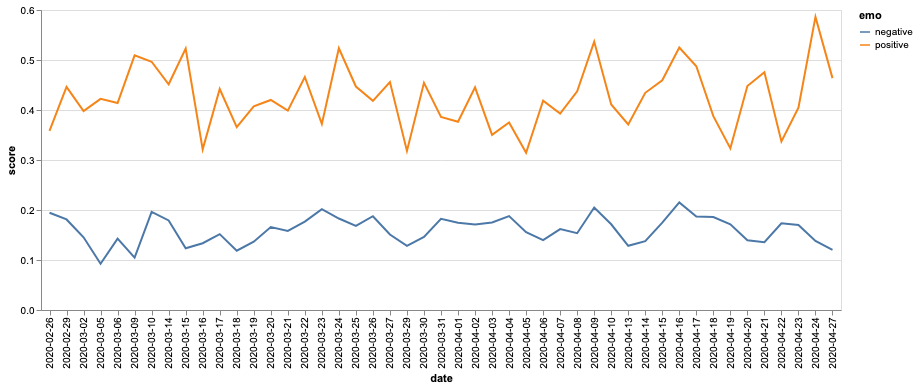

In [31]:
# ALL SPEAKERS, TRY TO FACET BY SPEAKERS?

briefings_by_date = briefings_df.groupby(['date']).mean().reset_index()
sentiment_by_date = briefings_by_date[['positive', 'negative', 'date']]
sentiment_by_date = sentiment_by_date.melt(['date'], var_name='emo', value_name='score')


alt.Chart(sentiment_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

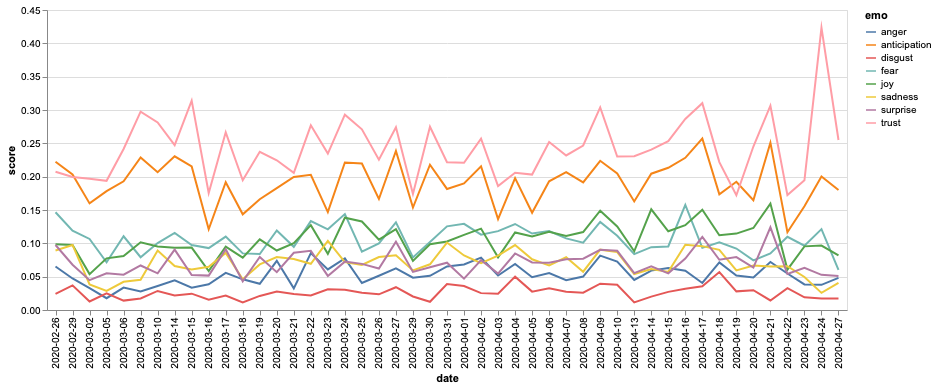

In [32]:
emotion_by_date = briefings_by_date.drop(columns=['topic_score', 'positive', 'negative'])
emotion_by_date = emotion_by_date.melt(['date'], var_name='emo', value_name='score')
emotion_by_date

alt.Chart(emotion_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

In [33]:
# strong fear and sadness scores on 2020-04-16
briefings_by_date.sort_values(by='fear', ascending=False).head(5)

,date,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_score
37,2020-04-16,0.058878,0.228242,0.032031,0.157563,0.127144,0.215170,0.524877,0.097843,0.077167,0.286538,0.589919
0,2020-02-26,0.065207,0.222378,0.024031,0.146694,0.098652,0.194487,0.358325,0.089214,0.097500,0.207472,0.602664
17,2020-03-24,0.077349,0.221314,0.030429,0.143809,0.138364,0.182970,0.523523,0.071784,0.072550,0.293051,0.596204
15,2020-03-22,0.085298,0.202848,0.021909,0.133302,0.127247,0.176764,0.466053,0.069269,0.088680,0.277016,0.592209
32,2020-04-09,0.081636,0.223851,0.039474,0.132022,0.148904,0.205034,0.536797,0.090515,0.090192,0.303825,0.584613


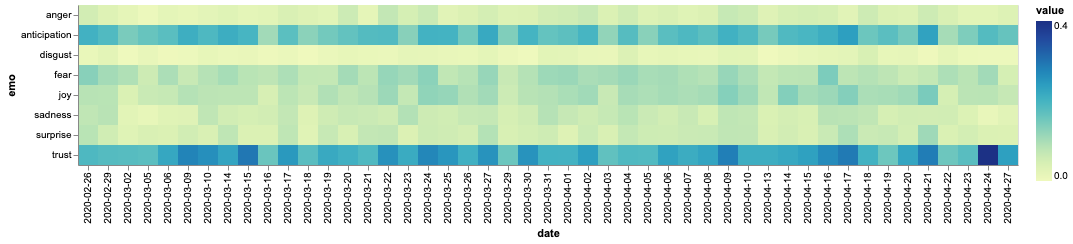

In [34]:
speaker_feels = briefings_df
speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


alt.Chart(speaker_feels_by_date).mark_rect().encode(
    x='date:O',
    y='emo:N',
    color='value:Q'
)

In [35]:
# plot heatmap by date for a speaker

def emo_date_heatmap(speaker):
    speaker_feels = briefings_df[briefings_df['speaker']==speaker]
    speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
    speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
    speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


    plot = alt.Chart(speaker_feels_by_date).mark_rect().encode(
        x='date:O',
        y='emo:N',
        color='value:Q'
    ).properties(title = speaker)
    
    return plot

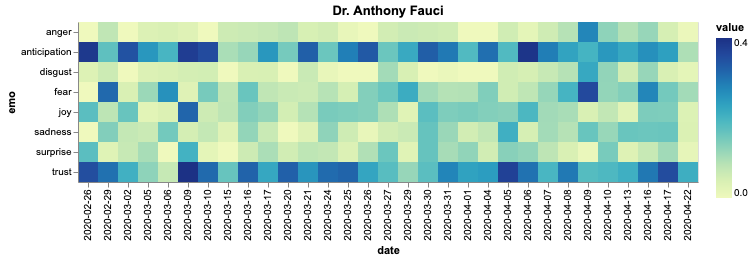

In [36]:
emo_date_heatmap('Dr. Anthony Fauci')

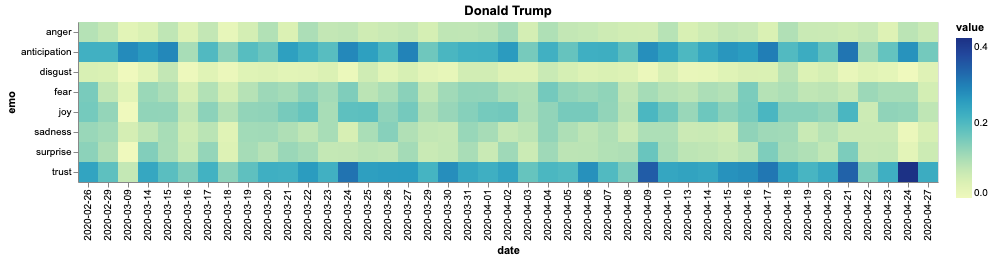

In [37]:
emo_date_heatmap('Donald Trump')

### Topics:

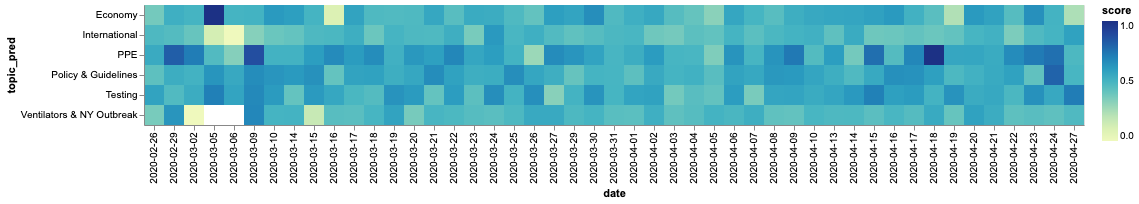

In [38]:
topics_by_date = briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
topics_by_date = topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(topics_by_date[topics_by_date['emo'] == 'positive']).mark_rect().encode(
    x='date:O',
    y='topic_pred:O',
    color='score:Q'
)

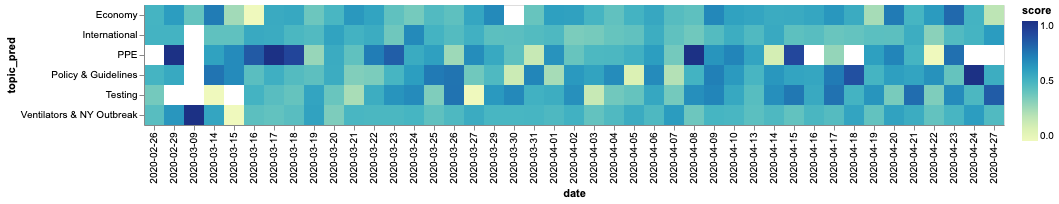

In [39]:
trump_briefings_df = briefings_df[briefings_df['speaker'] == 'Donald Trump']
trump_topics_by_date = trump_briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
trump_topics_by_date = trump_topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(trump_topics_by_date[trump_topics_by_date['emo'] == 'positive']).mark_rect().encode(
    x='date:O',
    y='topic_pred:O',
    color='score:Q'
)

### Scratchpad for other ideas:

In [40]:
# query for specific terms rather than topics
# chloroquine, ventilator, remdesivir etc

briefings_df[briefings_df['text'].str.contains("China")][100:110]

,date,timestamp,speaker,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pp_text,topic_pred,topic_score
2128,2020-03-20,01:06:25,Unnamed,[crosstalk 01:06:25] I have two questions. The...,0.000000,0.333333,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,"[crosstalk, question, secretary, pompeo, news,...",International,0.558708
2133,2020-03-20,01:07:18,Mike Pompeo,May I just say one more thing. There’s been so...,0.000000,0.222222,0.000000,0.333333,0.111111,0.555556,0.555556,0.111111,0.000000,0.000000,"[thing, discussion, china, know, know, critica...",Policy & Guidelines,0.358709
2134,2020-03-20,01:08:02,Mike Pompeo,"This is absolutely, this transparency, this re...",0.125000,0.375000,0.125000,0.250000,0.000000,0.500000,0.625000,0.125000,0.000000,0.250000,"[transparency, realtime, information, sharing,...",Policy & Guidelines,0.468484
2147,2020-03-20,01:11:27,Dr. Anthony Fauci,"Thank you, Mr. President. First of all, I thin...",0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,"[thank, mr, president, think, false, equivalen...",International,0.602451
2224,2020-03-20,01:32:32,Dr. Anthony Fauci,The possibility of aerosol transmission always...,0.000000,0.400000,0.000000,0.200000,0.000000,0.200000,0.200000,0.000000,0.000000,0.200000,"[possibility, aerosol, transmission, come, sit...",International,0.487770
2375,2020-03-21,01:03:19,Donald Trump,"Well, I love whoever you’re with that’s becaus...",0.000000,0.142857,0.000000,0.000000,0.142857,0.285714,0.428571,0.000000,0.142857,0.142857,"[love, think, nice, nice, question, think, was...",International,0.869140
2377,2020-03-21,01:05:01,Donald Trump,That’s the game. Win with as few lives lost as...,0.285714,0.142857,0.142857,0.142857,0.142857,0.714286,0.142857,0.428571,0.000000,0.285714,"[game, win, life, lose, possible, tough, enemy...",International,0.570702
2399,2020-03-21,01:09:52,Donald Trump,"When I learned I started doing the closing, so...",0.000000,0.666667,0.000000,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000,0.333333,"[learn, start, closing, time, learn, think, go...",International,0.965033
2402,2020-03-21,01:10:37,Donald Trump,They didn’t have that time. They read about it...,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,1.000000,0.000000,0.000000,1.000000,"[time, read, newspaper, like, china, secretive...",International,0.869386
2407,2020-03-21,01:11:21,Unnamed,Because as you were saying China was extremely...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,"[say, china, secretive, advisor, critical, chi...",International,0.487411


In [41]:
for i in briefings_df.sort_values(by='topic_score', ascending=False)['text'].head(5):
    print(i)
    print()

Dr Fauci spoke about it yesterday and we’ll reflect on his perspective on that as well. Tomorrow with the surgeon general and others on the White House team, we’ll be speaking with leaders in the African American community and as Dr Fauci will reflect, there have been historic challenges in the healthcare of the African African American communities. Particularly in our inner cities and now more than ever, I’ll just say from my heart to all of our African American family members now more than ever, practice the guidelines. Look after those most vulnerable people that have underlying serious health conditions. It’s more important than ever that we all put those principles into practice. Finally today, after we hear from Dr Fauci and Dr. Birx, I’m going to ask Dr Redfield to step up because today the CDC will be publishing new guidance on essential critical workers who have been exposed to COVID-19 but don’t have any symptoms. Don’t have a temperature and don’t have any reason to believe 

> revisit emotion calcs: index 2377 "That's the game" is a good one to check out.

> calculate emotion scores for an entire session overall


> how sentiments/topics compare between speaker

> how sentiments/topics have evolved over the pandemic.   

> SHOW MOST FEARFUL/ANGRY PORTIONS

> filter out the topic predictions below a certain strength ?



In [42]:


# https://www.rev.com/blog/transcript-tag/andrew-cuomo-transcripts/page/5
    
# https://www.rev.com/blog/transcript-tag/canada-coronavirus-briefing-transcripts/page/3